In [38]:
import re
from enum import Enum
from typing import List, Tuple, Dict, Set, Optional, Union, Any, Callable
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [39]:
def replace_multiple_spaces_by_one(s):
    return re.sub(r" +", " ", s)

In [40]:
class Unit(Enum):
    ns = 1000000000
    us = 1000000
    ms = 1000
    s = 1

    def __str__(self):
        return self.name

def get_unit(s):
    unit = s.replace("/op", "")
    if unit == "ns":
        return Unit.ns
    elif unit == "us":
        return Unit.us
    elif unit == "ms":
        return Unit.ms
    elif unit == "s":
        return Unit.s
    else:
        raise Exception("Unknown unit")
    
def convert(n:float, current_unit:Unit, new_unit:Unit) -> float:
    return n * current_unit.value / new_unit.value

def verify_unit_or_convert(data: Tuple[Unit, List[Tuple[int, float, float]]], other_data: Tuple[Unit, List[Tuple[int, float, float]]] = ()) -> Tuple[Unit, List[Tuple[int, float, float]]]:
    unit = data[0] if other_data == () else other_data[0]
    u = data[0]
    res = [(x, convert(avg, u, unit), convert(err, u, unit)) for x, avg, err in data[1]]
    res.sort()
    return (unit, res)

In [41]:

def plot_data(data1: Tuple[Unit, List[Tuple[int, float, float]]], data1_name: str, data2: Tuple[Unit, List[Tuple[int, float, float]]], data2_name: str):
    unit1, dat1 = data1
    unit2, dat2 = data2
    assert unit1 == unit2
    fig, ax = plt.subplots(figsize=(12, 6))

    ax.plot([x for x, _, _ in dat1], [y for _, y, _ in dat1], label=data1_name)
    ax.plot([x for x, _, _ in dat2], [y for _, y, _ in dat2], label=data2_name)
    ax.xlabel("Number of elements")
    ax.ylabel(f"Time ({unit1})")

    ax.legend()
    ax.show()

In [42]:
import matplotlib.pyplot as plt
from typing import Tuple, List, Optional

def plot_data_with_error(plot_name: str,
                         data: Dict[str, Tuple[str, List[Tuple[int, float, float]]]],
                          x_line_at: int = 0, 
                          show_avg: bool = False, 
                          output_folder = ""):
    final_unit = None
    data_without_units: Dict[str, List[Tuple[int, float, float]]]= {}
    for name, (unit, dat) in data.items():
        data_without_units[name] = dat
        if final_unit is not None:
            assert final_unit == unit
        else:
            final_unit = unit
    
    assert len(data.keys()) <= 8


    fig, ax = plt.subplots()

    # Choose colorblind-friendly colors
    colours = ['tab:blue', 'tab:cyan', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
    colorBlack = 'black'

    # the error bar is shown in another color, and it the 99% CI
    # The y-axis always starts at 0
    for i, (name, dat) in enumerate(data_without_units.items()):
        ax.errorbar([x for x, _, _ in dat], [y for _, y, _ in dat], yerr=[y for _, _, y in dat], label=name, ecolor=colorBlack, elinewidth=0.8, capsize=2, capthick=0.8, color=colours[i % len(colours)])

    avgs = {}
    for name, dat in data_without_units.items():
        avgs[name] = sum([y for _, y, _ in dat]) / len(dat) if len(dat) > 0 else 0

    max_y_value = max([y for l in data_without_units.values() for _, y, _ in l])

    max_y_value = max_y_value + 0.15 * max_y_value
    ax.set_xlabel("N")
    ax.set_ylabel(f"Time ({final_unit})")

    # Add a vertical line at x = x_line_at if not 0
    if x_line_at != 0:
        ax.axvline(x=x_line_at, color=colorBlack, linestyle='--')

    if show_avg:
        for name, avg in avgs.items():
            ax.axhline(y=avg, color=colours[list(avgs.keys()).index(name)], linestyle='--')

    ax.legend()
    ax.set_title(plot_name)
    
    if output_folder != "":
        # fig.savefig(f"{output_folder}/{plot_name}.png", format='png', dpi=1200)
        file_name = plot_name.replace(" - ", "_").replace(" ", "_").replace("^", "to").replace("&", "and").replace(",", "").replace("(", "").replace(")", "").replace(":", "").replace("/", "_")
        fig.savefig(f"{output_folder}/{file_name}.eps", format='eps')

    plt.show()


In [43]:
def extract_data(df: pd.DataFrame , benchmark_name: str, map_type_name: str, x_var_name: str) -> Tuple[Unit, List[Tuple[int, float, float]]]:
    benchmark_name = f"{benchmark_name}_{map_type_name}"
    data = df[df["Benchmark"].str.contains(benchmark_name)]
    unit = get_unit(df["Units"].to_list()[0])
    return (unit, [(int(param), float(avg), float(err)) for param, avg, err in data[[f"({x_var_name})", "Score", "Error"]].to_numpy()])

def extract_data_normalised_per_op(df: pd.DataFrame , benchmark_name: str, map_type_name: str, x_var_name: str) -> Tuple[Unit, List[Tuple[int, float, float]]]:
    benchmark_name = f"{benchmark_name}_{map_type_name}"
    data = df[df["Benchmark"].str.contains(benchmark_name)]
    unit = get_unit(df["Units"].to_list()[0])
    return (unit, [(int(param), float(avg)/float(param), float(err)/float(param) ) for param, avg, err in data[[f"({x_var_name})", "Score", "Error"]].to_numpy() if int(param) != 0] )


In [44]:
def create_plots(benchmark_classes: List[str], benchmark_names: Dict[str, List[str]], df: pd.DataFrame, variable_names: Dict[str, str] = {}, show_avg_for: str = "never", output_folder = ""):
    for c in benchmark_classes:
        benchmark_func_names = benchmark_names[c]
        for n in benchmark_func_names:
            if variable_names != {}:
                variable_name = variable_names[c]
            else:
                # Only for legacy reasons
                variable_name = "n" if "LongListMapBenchmark" in c else "keysListName"
            map1_name = "ArrayFill"
            map2_name = "EfficientFill"
            map3_name = "Constructor"
            benchm_name = f"{c}.{n}"
            bench_name_pretty = f"{n}"
            map1_data = verify_unit_or_convert(extract_data(df, benchm_name, map1_name, variable_name))
            map2_data = verify_unit_or_convert(extract_data(df, benchm_name, map2_name, variable_name), map1_data)
            map3_data = verify_unit_or_convert(extract_data(df, benchm_name, map3_name, variable_name), map1_data)
            x_line_at = 0

            data = {}
            data[map1_name] = map1_data
            data[map2_name] = map2_data
            data[map3_name] = map3_data


            plot_data_with_error(bench_name_pretty, data, x_line_at, show_avg_for == "always", output_folder)


# Array.fill Benchmark

In [45]:
data = """[info] Benchmark                                         (size)  Mode  Cnt       Score        Error  Units
[info] ArrayFillBenchmark.fillLong_ArrayFill                  2  avgt   10       0.016 ±      0.001  us/op
[info] ArrayFillBenchmark.fillLong_ArrayFill                  4  avgt   10       0.019 ±      0.001  us/op
[info] ArrayFillBenchmark.fillLong_ArrayFill                  8  avgt   10       0.022 ±      0.001  us/op
[info] ArrayFillBenchmark.fillLong_ArrayFill                 16  avgt   10       0.025 ±      0.001  us/op
[info] ArrayFillBenchmark.fillLong_ArrayFill                 32  avgt   10       0.035 ±      0.001  us/op
[info] ArrayFillBenchmark.fillLong_ArrayFill                 64  avgt   10       0.078 ±      0.001  us/op
[info] ArrayFillBenchmark.fillLong_ArrayFill                128  avgt   10       0.208 ±      0.002  us/op
[info] ArrayFillBenchmark.fillLong_ArrayFill                256  avgt   10       0.333 ±      0.003  us/op
[info] ArrayFillBenchmark.fillLong_ArrayFill                512  avgt   10       0.608 ±      0.006  us/op
[info] ArrayFillBenchmark.fillLong_ArrayFill               1024  avgt   10       1.151 ±      0.008  us/op
[info] ArrayFillBenchmark.fillLong_ArrayFill               2048  avgt   10       2.208 ±      0.011  us/op
[info] ArrayFillBenchmark.fillLong_ArrayFill               4096  avgt   10       4.419 ±      0.022  us/op
[info] ArrayFillBenchmark.fillLong_ArrayFill               8192  avgt   10       9.600 ±      0.122  us/op
[info] ArrayFillBenchmark.fillLong_ArrayFill              16384  avgt   10      28.231 ±      0.236  us/op
[info] ArrayFillBenchmark.fillLong_ArrayFill              32768  avgt   10      56.104 ±      0.680  us/op
[info] ArrayFillBenchmark.fillLong_ArrayFill              65536  avgt   10     119.554 ±      0.811  us/op
[info] ArrayFillBenchmark.fillLong_ArrayFill             131072  avgt   10     238.019 ±      1.264  us/op
[info] ArrayFillBenchmark.fillLong_ArrayFill             262144  avgt   10     475.168 ±      2.546  us/op
[info] ArrayFillBenchmark.fillLong_ArrayFill             524288  avgt   10     942.896 ±      5.616  us/op
[info] ArrayFillBenchmark.fillLong_ArrayFill            1048576  avgt   10    1847.358 ±     14.344  us/op
[info] ArrayFillBenchmark.fillLong_ArrayFill            2097152  avgt   10    3969.722 ±     35.000  us/op
[info] ArrayFillBenchmark.fillLong_ArrayFill            4194304  avgt   10    9442.788 ±     77.565  us/op
[info] ArrayFillBenchmark.fillLong_ArrayFill            8388608  avgt   10   19333.648 ±    198.710  us/op
[info] ArrayFillBenchmark.fillLong_ArrayFill           16777216  avgt   10   38830.098 ±    377.648  us/op
[info] ArrayFillBenchmark.fillLong_ArrayFill           33554432  avgt   10   77692.873 ±    536.285  us/op
[info] ArrayFillBenchmark.fillLong_Constructor                2  avgt   10       0.010 ±      0.001  us/op
[info] ArrayFillBenchmark.fillLong_Constructor                4  avgt   10       0.010 ±      0.001  us/op
[info] ArrayFillBenchmark.fillLong_Constructor                8  avgt   10       0.014 ±      0.001  us/op
[info] ArrayFillBenchmark.fillLong_Constructor               16  avgt   10       0.016 ±      0.001  us/op
[info] ArrayFillBenchmark.fillLong_Constructor               32  avgt   10       0.030 ±      0.001  us/op
[info] ArrayFillBenchmark.fillLong_Constructor               64  avgt   10       0.069 ±      0.001  us/op
[info] ArrayFillBenchmark.fillLong_Constructor              128  avgt   10       0.160 ±      0.001  us/op
[info] ArrayFillBenchmark.fillLong_Constructor              256  avgt   10       0.287 ±      0.003  us/op
[info] ArrayFillBenchmark.fillLong_Constructor              512  avgt   10       0.526 ±      0.004  us/op
[info] ArrayFillBenchmark.fillLong_Constructor             1024  avgt   10       0.997 ±      0.005  us/op
[info] ArrayFillBenchmark.fillLong_Constructor             2048  avgt   10       1.948 ±      0.013  us/op
[info] ArrayFillBenchmark.fillLong_Constructor             4096  avgt   10       3.869 ±      0.052  us/op
[info] ArrayFillBenchmark.fillLong_Constructor             8192  avgt   10       7.781 ±      0.100  us/op
[info] ArrayFillBenchmark.fillLong_Constructor            16384  avgt   10      22.587 ±      0.246  us/op
[info] ArrayFillBenchmark.fillLong_Constructor            32768  avgt   10      44.767 ±      0.251  us/op
[info] ArrayFillBenchmark.fillLong_Constructor            65536  avgt   10      94.657 ±      0.886  us/op
[info] ArrayFillBenchmark.fillLong_Constructor           131072  avgt   10     189.618 ±      2.017  us/op
[info] ArrayFillBenchmark.fillLong_Constructor           262144  avgt   10     378.284 ±      3.655  us/op
[info] ArrayFillBenchmark.fillLong_Constructor           524288  avgt   10     765.024 ±      5.500  us/op
[info] ArrayFillBenchmark.fillLong_Constructor          1048576  avgt   10    1525.803 ±     12.743  us/op
[info] ArrayFillBenchmark.fillLong_Constructor          2097152  avgt   10    3081.842 ±    168.196  us/op
[info] ArrayFillBenchmark.fillLong_Constructor          4194304  avgt   10    6082.915 ±     50.360  us/op
[info] ArrayFillBenchmark.fillLong_Constructor          8388608  avgt   10   12067.926 ±     58.504  us/op
[info] ArrayFillBenchmark.fillLong_Constructor         16777216  avgt   10   24165.231 ±    174.331  us/op
[info] ArrayFillBenchmark.fillLong_Constructor         33554432  avgt   10   49223.927 ±   5399.450  us/op
[info] ArrayFillBenchmark.fillLong_EfficientFill              2  avgt   10       0.012 ±      0.001  us/op
[info] ArrayFillBenchmark.fillLong_EfficientFill              4  avgt   10       0.015 ±      0.001  us/op
[info] ArrayFillBenchmark.fillLong_EfficientFill              8  avgt   10       0.017 ±      0.001  us/op
[info] ArrayFillBenchmark.fillLong_EfficientFill             16  avgt   10       0.020 ±      0.001  us/op
[info] ArrayFillBenchmark.fillLong_EfficientFill             32  avgt   10       0.031 ±      0.001  us/op
[info] ArrayFillBenchmark.fillLong_EfficientFill             64  avgt   10       0.073 ±      0.001  us/op
[info] ArrayFillBenchmark.fillLong_EfficientFill            128  avgt   10       0.181 ±      0.002  us/op
[info] ArrayFillBenchmark.fillLong_EfficientFill            256  avgt   10       0.332 ±      0.004  us/op
[info] ArrayFillBenchmark.fillLong_EfficientFill            512  avgt   10       0.602 ±      0.008  us/op
[info] ArrayFillBenchmark.fillLong_EfficientFill           1024  avgt   10       1.128 ±      0.010  us/op
[info] ArrayFillBenchmark.fillLong_EfficientFill           2048  avgt   10       2.165 ±      0.016  us/op
[info] ArrayFillBenchmark.fillLong_EfficientFill           4096  avgt   10       4.356 ±      0.050  us/op
[info] ArrayFillBenchmark.fillLong_EfficientFill           8192  avgt   10       9.445 ±      0.067  us/op
[info] ArrayFillBenchmark.fillLong_EfficientFill          16384  avgt   10      28.078 ±      0.268  us/op
[info] ArrayFillBenchmark.fillLong_EfficientFill          32768  avgt   10      55.715 ±      0.482  us/op
[info] ArrayFillBenchmark.fillLong_EfficientFill          65536  avgt   10     119.112 ±      0.740  us/op
[info] ArrayFillBenchmark.fillLong_EfficientFill         131072  avgt   10     238.215 ±      1.904  us/op
[info] ArrayFillBenchmark.fillLong_EfficientFill         262144  avgt   10     476.875 ±      3.144  us/op
[info] ArrayFillBenchmark.fillLong_EfficientFill         524288  avgt   10     930.471 ±      8.508  us/op
[info] ArrayFillBenchmark.fillLong_EfficientFill        1048576  avgt   10    1846.630 ±     19.632  us/op
[info] ArrayFillBenchmark.fillLong_EfficientFill        2097152  avgt   10    3923.924 ±     19.971  us/op
[info] ArrayFillBenchmark.fillLong_EfficientFill        4194304  avgt   10    9367.818 ±     37.759  us/op
[info] ArrayFillBenchmark.fillLong_EfficientFill        8388608  avgt   10   19254.442 ±    234.341  us/op
[info] ArrayFillBenchmark.fillLong_EfficientFill       16777216  avgt   10   39947.215 ±   2068.732  us/op
[info] ArrayFillBenchmark.fillLong_EfficientFill       33554432  avgt   10   77280.139 ±   1104.198  us/op
[info] ArrayFillBenchmark.fillValueCell_ArrayFill             2  avgt   10       0.023 ±      0.001  us/op
[info] ArrayFillBenchmark.fillValueCell_ArrayFill             4  avgt   10       0.029 ±      0.001  us/op
[info] ArrayFillBenchmark.fillValueCell_ArrayFill             8  avgt   10       0.041 ±      0.001  us/op
[info] ArrayFillBenchmark.fillValueCell_ArrayFill            16  avgt   10       0.066 ±      0.001  us/op
[info] ArrayFillBenchmark.fillValueCell_ArrayFill            32  avgt   10       0.118 ±      0.001  us/op
[info] ArrayFillBenchmark.fillValueCell_ArrayFill            64  avgt   10       0.236 ±      0.001  us/op
[info] ArrayFillBenchmark.fillValueCell_ArrayFill           128  avgt   10       0.396 ±      0.006  us/op
[info] ArrayFillBenchmark.fillValueCell_ArrayFill           256  avgt   10       0.816 ±      0.014  us/op
[info] ArrayFillBenchmark.fillValueCell_ArrayFill           512  avgt   10       1.617 ±      0.009  us/op
[info] ArrayFillBenchmark.fillValueCell_ArrayFill          1024  avgt   10       3.140 ±      0.043  us/op
[info] ArrayFillBenchmark.fillValueCell_ArrayFill          2048  avgt   10       6.230 ±      0.067  us/op
[info] ArrayFillBenchmark.fillValueCell_ArrayFill          4096  avgt   10      12.366 ±      0.164  us/op
[info] ArrayFillBenchmark.fillValueCell_ArrayFill          8192  avgt   10      24.929 ±      1.196  us/op
[info] ArrayFillBenchmark.fillValueCell_ArrayFill         16384  avgt   10      49.337 ±      1.013  us/op
[info] ArrayFillBenchmark.fillValueCell_ArrayFill         32768  avgt   10     102.588 ±      0.675  us/op
[info] ArrayFillBenchmark.fillValueCell_ArrayFill         65536  avgt   10     206.344 ±      2.794  us/op
[info] ArrayFillBenchmark.fillValueCell_ArrayFill        131072  avgt   10     415.607 ±      4.148  us/op
[info] ArrayFillBenchmark.fillValueCell_ArrayFill        262144  avgt   10     850.627 ±     11.256  us/op
[info] ArrayFillBenchmark.fillValueCell_ArrayFill        524288  avgt   10    1681.934 ±     65.948  us/op
[info] ArrayFillBenchmark.fillValueCell_ArrayFill       1048576  avgt   10   20444.451 ±   1261.024  us/op
[info] ArrayFillBenchmark.fillValueCell_ArrayFill       2097152  avgt   10   40287.492 ±   3402.079  us/op
[info] ArrayFillBenchmark.fillValueCell_ArrayFill       4194304  avgt   10   75685.718 ±  10842.953  us/op
[info] ArrayFillBenchmark.fillValueCell_ArrayFill       8388608  avgt   10  147428.982 ±  19521.080  us/op
[info] ArrayFillBenchmark.fillValueCell_ArrayFill      16777216  avgt   10  269937.970 ±  26364.889  us/op
[info] ArrayFillBenchmark.fillValueCell_ArrayFill      33554432  avgt   10  562710.726 ±  61140.196  us/op
[info] ArrayFillBenchmark.fillValueCell_Constructor           2  avgt   10       0.010 ±      0.001  us/op
[info] ArrayFillBenchmark.fillValueCell_Constructor           4  avgt   10       0.010 ±      0.001  us/op
[info] ArrayFillBenchmark.fillValueCell_Constructor           8  avgt   10       0.011 ±      0.001  us/op
[info] ArrayFillBenchmark.fillValueCell_Constructor          16  avgt   10       0.015 ±      0.001  us/op
[info] ArrayFillBenchmark.fillValueCell_Constructor          32  avgt   10       0.016 ±      0.001  us/op
[info] ArrayFillBenchmark.fillValueCell_Constructor          64  avgt   10       0.029 ±      0.001  us/op
[info] ArrayFillBenchmark.fillValueCell_Constructor         128  avgt   10       0.069 ±      0.001  us/op
[info] ArrayFillBenchmark.fillValueCell_Constructor         256  avgt   10       0.159 ±      0.001  us/op
[info] ArrayFillBenchmark.fillValueCell_Constructor         512  avgt   10       0.285 ±      0.002  us/op
[info] ArrayFillBenchmark.fillValueCell_Constructor        1024  avgt   10       0.526 ±      0.008  us/op
[info] ArrayFillBenchmark.fillValueCell_Constructor        2048  avgt   10       0.996 ±      0.011  us/op
[info] ArrayFillBenchmark.fillValueCell_Constructor        4096  avgt   10       1.926 ±      0.011  us/op
[info] ArrayFillBenchmark.fillValueCell_Constructor        8192  avgt   10       3.850 ±      0.036  us/op
[info] ArrayFillBenchmark.fillValueCell_Constructor       16384  avgt   10       7.721 ±      0.067  us/op
[info] ArrayFillBenchmark.fillValueCell_Constructor       32768  avgt   10      22.615 ±      0.248  us/op
[info] ArrayFillBenchmark.fillValueCell_Constructor       65536  avgt   10      45.279 ±      0.762  us/op
[info] ArrayFillBenchmark.fillValueCell_Constructor      131072  avgt   10      94.354 ±      0.668  us/op
[info] ArrayFillBenchmark.fillValueCell_Constructor      262144  avgt   10     188.912 ±      0.770  us/op
[info] ArrayFillBenchmark.fillValueCell_Constructor      524288  avgt   10     376.552 ±      3.676  us/op
[info] ArrayFillBenchmark.fillValueCell_Constructor     1048576  avgt   10    2387.147 ±     76.159  us/op
[info] ArrayFillBenchmark.fillValueCell_Constructor     2097152  avgt   10    4644.393 ±    157.087  us/op
[info] ArrayFillBenchmark.fillValueCell_Constructor     4194304  avgt   10    9963.794 ±    506.617  us/op
[info] ArrayFillBenchmark.fillValueCell_Constructor     8388608  avgt   10   22811.995 ±   1472.636  us/op
[info] ArrayFillBenchmark.fillValueCell_Constructor    16777216  avgt   10   42791.958 ±   1444.880  us/op
[info] ArrayFillBenchmark.fillValueCell_Constructor    33554432  avgt   10   87016.150 ±   1302.966  us/op
[info] ArrayFillBenchmark.fillValueCell_EfficientFill         2  avgt   10       0.016 ±      0.001  us/op
[info] ArrayFillBenchmark.fillValueCell_EfficientFill         4  avgt   10       0.020 ±      0.001  us/op
[info] ArrayFillBenchmark.fillValueCell_EfficientFill         8  avgt   10       0.026 ±      0.001  us/op
[info] ArrayFillBenchmark.fillValueCell_EfficientFill        16  avgt   10       0.040 ±      0.001  us/op
[info] ArrayFillBenchmark.fillValueCell_EfficientFill        32  avgt   10       0.070 ±      0.001  us/op
[info] ArrayFillBenchmark.fillValueCell_EfficientFill        64  avgt   10       0.119 ±      0.001  us/op
[info] ArrayFillBenchmark.fillValueCell_EfficientFill       128  avgt   10       0.200 ±      0.001  us/op
[info] ArrayFillBenchmark.fillValueCell_EfficientFill       256  avgt   10       0.446 ±      0.003  us/op
[info] ArrayFillBenchmark.fillValueCell_EfficientFill       512  avgt   10       0.839 ±      0.008  us/op
[info] ArrayFillBenchmark.fillValueCell_EfficientFill      1024  avgt   10       1.647 ±      0.012  us/op
[info] ArrayFillBenchmark.fillValueCell_EfficientFill      2048  avgt   10       3.275 ±      0.035  us/op
[info] ArrayFillBenchmark.fillValueCell_EfficientFill      4096  avgt   10       6.548 ±      0.056  us/op
[info] ArrayFillBenchmark.fillValueCell_EfficientFill      8192  avgt   10      13.067 ±      0.094  us/op
[info] ArrayFillBenchmark.fillValueCell_EfficientFill     16384  avgt   10      31.044 ±      0.180  us/op
[info] ArrayFillBenchmark.fillValueCell_EfficientFill     32768  avgt   10      80.165 ±      0.720  us/op
[info] ArrayFillBenchmark.fillValueCell_EfficientFill     65536  avgt   10     160.100 ±      0.840  us/op
[info] ArrayFillBenchmark.fillValueCell_EfficientFill    131072  avgt   10     320.227 ±      1.700  us/op
[info] ArrayFillBenchmark.fillValueCell_EfficientFill    262144  avgt   10     650.168 ±     10.904  us/op
[info] ArrayFillBenchmark.fillValueCell_EfficientFill    524288  avgt   10    1242.892 ±    143.287  us/op
[info] ArrayFillBenchmark.fillValueCell_EfficientFill   1048576  avgt   10   16584.042 ±    521.455  us/op
[info] ArrayFillBenchmark.fillValueCell_EfficientFill   2097152  avgt   10   39742.728 ±  50683.244  us/op
[info] ArrayFillBenchmark.fillValueCell_EfficientFill   4194304  avgt   10   54581.920 ±  22572.179  us/op
[info] ArrayFillBenchmark.fillValueCell_EfficientFill   8388608  avgt   10  105024.554 ±  48131.360  us/op
[info] ArrayFillBenchmark.fillValueCell_EfficientFill  16777216  avgt   10  203960.562 ±  76796.503  us/op
[info] ArrayFillBenchmark.fillValueCell_EfficientFill  33554432  avgt   10  427037.665 ± 236082.820  us/op""".strip().split("\n")


data = [replace_multiple_spaces_by_one(s.replace("[info]", "").replace("±", "")).replace(" ", ",") for s in data]
# create a panda dataframe from the data, using the first line as the column names
df = pd.DataFrame([s.split(",") for s in data[1:]], columns=data[0].split(","))
benchmark_classes = ["ArrayFillBenchmark"]

benchmark_names = {}
for n in benchmark_classes:
    benchmark_mutable_map_names = df["Benchmark"].unique().tolist()
    benchmark_mutable_map_names = [s.replace(f"{n}.", "") for s in benchmark_mutable_map_names if f"{n}." in s]
    benchmark_mutable_map_names = [s.replace("_ArrayFill", "").replace("_EfficientFill", "").replace("_Constructor", "") for s in benchmark_mutable_map_names]
    # remove duplicates
    benchmark_mutable_map_names = list(set(benchmark_mutable_map_names))
    benchmark_names[n] = benchmark_mutable_map_names
benchmark_names

variable_names = {}
for n in benchmark_classes:
    variable_names[n] = "size"

variable_names

{'ArrayFillBenchmark': 'size'}

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


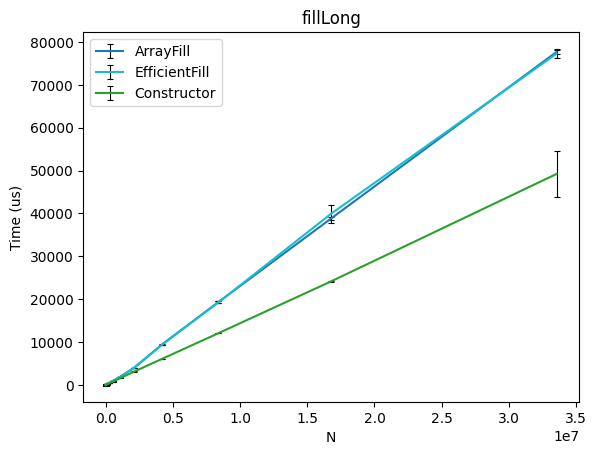

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


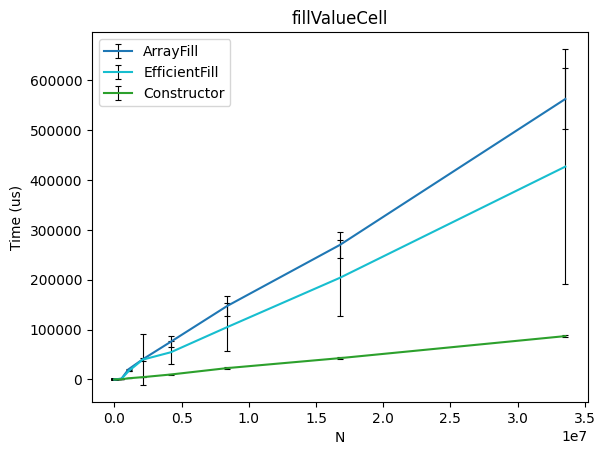

In [46]:
create_plots(benchmark_classes, benchmark_names, df, variable_names, show_avg_for="normalised", output_folder="./plots_array")